<a href="https://colab.research.google.com/github/kylerod22/siads593-water-sustainability/blob/Sungmin/Benchmark_Model_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview of the Analysis

This study explores river water quality across South Africa using exploratory analysis to better understand how environmental and human-related factors may influence conditions in rivers. Water quality samples were collected at river monitoring locations between 2011 and 2015, covering both inland rivers and rivers near the coast. To provide additional context for each sampling location, these measurements were combined with satellite data, climate information, population density, and indicators of how close each site is to a river mouth. Satellite observations help describe surface and moisture conditions, climate data capture broader weather influences, population density reflects nearby human activity, and river mouth proximity helps distinguish downstream and coastal effects from upstream conditions. Together, these data are used to examine patterns and relationships in three key water quality measures—Total Alkalinity (TA), Electrical Conductance (EC), and Dissolved Reactive Phosphorus (DRP)—and to gain insights into the factors associated with variation in river water quality.


<b>About the Notebook: </b><p align="justify"> <p>

<p align="justify"> In this notebook, we demonstrate a basic workflow that serves as a foundation for the challenge. The model has been developed to predict <b>water quality parameters</b> using features derived from the <b>Landsat</b> and <b>TerraClimate</b> datasets. Specifically, four spectral bands—<b>SWIR22</b> (Shortwave Infrared 2), <b>NIR</b> (Near Infrared), <b>Green</b>, and <b>SWIR16</b> (Shortwave Infrared 1)—were utilized from Landsat, along with derived spectral indices such as <b>NDMI</b> (Normalized Difference Moisture Index) and <b>MNDWI</b> (Modified Normalized Difference Water Index). In addition, the <b>PET</b> (Potential Evapotranspiration) variable was incorporated from the <b>TerraClimate</b> dataset to account for climatic influences on water quality. </p>

<p align="justify"> The dataset spans a five-year period from <b>2011 to 2015</b>. Using <b>API-based data extraction</b> methods, both Landsat and TerraClimate features were retrieved directly from the <a href="https://planetarycomputer.microsoft.com/">Microsoft Planetary Computer</a> portal. These combined spectral, index-based, and climatic features were used as predictors in a regression model to estimate three key water quality parameters: <b>Total Alkalinity (TA)</b>, <b>Electrical Conductance (EC)</b>, and <b>Dissolved Reactive Phosphorus (DRP)</b>.

</p> <p align="justify"> Please note that this notebook serves only as a starting point. Several assumptions were made during the data extraction and model development process, which you may find opportunities to improve upon. Participants are encouraged to explore additional features, enhance preprocessing techniques, or experiment with different regression algorithms to optimize predictive performance. </p>

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [ ]:
# # Install missing packages
!pip install rioxarray
!pip install pystac_client
!pip install planetary_computer
!pip install odc-stac

# # Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# # Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# # Data manipulation and analysis
import numpy as np
import pandas as pd

# # Multi-dimensional arrays and datasets (e.g., NetCDF, Zarr)
import xarray as xr

# # Geospatial raster data handling with CRS support
import rioxarray as rxr

# # Raster operations and spatial windowing
import rasterio
from rasterio.windows import Window

# # Feature preprocessing and data splitting
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.spatial import cKDTree

# # Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# # Planetary Computer tools for STAC API access and authentication
import pystac_client
import planetary_computer as pc
from odc.stac import stac_load
from pystac.extensions.eo import EOExtension as eo

from datetime import date
from tqdm import tqdm
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.2 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.12.0
    Uninstalling xarray-2025.12.0:
      Successfully uninstalled xarray-2025.12.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.0/159.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 4.7 MB/s eta 0:00:00


## Response Variable

<p align="justify">
Before building the model, we first load the <b>water quality training dataset</b>. The curated dataset contains samples collected from various monitoring stations across the study region. Each record includes the geographical coordinates (Latitude and Longitude), the sample collection date, and the corresponding <b>measured values</b> for the three key water quality parameters — <b>Total Alkalinity (TA)</b>, <b>Electrical Conductance (EC)</b>, and <b>Dissolved Reactive Phosphorus (DRP)</b>.
</p>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/My Drive/2026 EY Data Challenge/Dataset/water_quality_training_dataset.csv"

In [ ]:
import pandas as pd
Water_Quality_df=pd.read_csv(file_path)
Water_Quality_df.head()

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
0,-28.760833,17.730278,02-01-2011,128.912,555.0,10.0
1,-26.861111,28.884722,03-01-2011,74.720,162.9,163.0
2,-26.450000,28.085833,03-01-2011,89.254,573.0,80.0
3,-27.671111,27.236944,03-01-2011,82.000,203.6,101.0
4,-27.356667,27.286389,03-01-2011,56.100,145.1,151.0


## Predictor Variables

<p align="justify">
Now that we have our water quality dataset, the next step is to gather the predictor variables from the <b>Landsat</b> and <b>TerraClimate</b> datasets. In this notebook, we demonstrate how to <b>load previously extracted satellite and climate data</b> from separate files, rather than performing the extraction directly, which allows for a smoother and faster experience. Participants can refer to the dedicated extraction notebooks—one for Landsat and another for TerraClimate—to understand how the data was retrieved and processed, and they can also generate their own output CSV files if needed. Using these pre-extracted CSV files, this notebook focuses on loading the predictor features and running the subsequent analysis and model training efficiently.
</p>
<p align="justify">
For more detailed guidance on the original data extraction process, you can review the <a href="https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2#Example-Notebook">Landsat example notebook</a> and the <a href="https://planetarycomputer.microsoft.com/dataset/terraclimate#Example-Notebook">TerraClimate example notebook</a> available on the Planetary Computer portal.
</p>

<p align="justify">We have used selected spectral bands — SWIR22 (Shortwave Infrared 2), NIR (Near Infrared), Green, and SWIR16 (Shortwave Infrared 1) — and computed key spectral indices such as NDMI (Normalized Difference Moisture Index) and MNDWI (Modified Normalized Difference Water Index). These features capture surface moisture, vegetation, and water content characteristics that influence water quality variability. </p> <p align="justify"> In addition to Landsat features, we also incorporated the <b>Potential Evapotranspiration (PET)</b> variable from the <b>TerraClimate</b> dataset, which provides high-resolution global climate data. The PET feature captures the atmospheric demand for moisture, representing climatic conditions such as temperature, humidity, and radiation that influence surface water evaporation and thus affect water quality parameters. </p> <ul> <li>SWIR22 – Sensitive to surface moisture and turbidity variations in water bodies.</li> <li>NIR – Helps in identifying vegetation and suspended matter in water.</li> <li>Green – Useful for detecting water color and surface reflectance changes.</li> <li>SWIR16 – Provides information on surface dryness and sediment concentration.</li> <li>NDMI – Derived from NIR and SWIR16, indicates moisture and vegetation-water interaction.</li> <li>MNDWI – Derived from Green and SWIR22, effective for distinguishing open water areas and reducing built-up noise.</li> <li>PET – Extracted from the TerraClimate dataset, represents the potential evapotranspiration that influences hydrological and water quality dynamics.</li> </ul>

<h4 style="color:rgb(255, 0, 0)"><strong>Tip 1</strong></h4>  
<p align="justify">  
Participants are encouraged to experiment with different combinations of <b>Landsat</b> bands or even include data from other public satellite data sources. By creating mathematical combinations of bands, you can derive various spectral indices that capture surface and environmental characteristics.
</p>


<h3>Loading Pre-Extracted Landsat Data</h3>
<p align="justify">
In this notebook, we <b>load previously extracted Landsat data</b> from CSV files generated in a separate extraction notebook. This approach ensures a smoother and faster workflow, allowing participants to focus on data analysis and model development without waiting for time-consuming data retrieval.
</p>
<p align="justify">
Participants are expected to generate their own data extraction CSV files by running the dedicated Landsat extraction notebook. These CSV files can then be used here to smoothly run this benchmark notebook. Participants can refer to the extraction notebook to understand the API-based process, including how individual bands and indices like <b>NDMI</b> were computed. Using these pre-extracted CSV files simplifies preprocessing and is ideal for large-scale environmental and water quality analysis.
</p>


<h4 style="color:rgb(255, 0, 0)"><strong>Tip 2</strong></h4>
In the data extraction process (performed in the dedicated extraction notebooks), a 100 m focal buffer was applied around each sampling location rather than using a single point. Participants may explore creating different focal buffers around the locations (e.g., 50 m, 150 m, etc.) during extraction. For example, if a 50 m buffer was used for “Band 2”, the extracted CSV values would reflect the average of "Band 2" within 50 meters of each location. This approach can help reduce errors associated with spatial autocorrelation.


In [ ]:
file_path1 = "/content/drive/My Drive/2026 EY Data Challenge/Dataset/landsat_features_training.csv"

In [ ]:
landsat_train_features = pd.read_csv(file_path1)
landsat_train_features.head()

,Latitude,Longitude,Sample Date,nir,green,swir16,swir22,NDMI,MNDWI
0,-28.760833,17.730278,02-01-2011,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595
1,-26.861111,28.884722,03-01-2011,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134
2,-26.450000,28.085833,03-01-2011,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805
3,-27.671111,27.236944,03-01-2011,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416
4,-27.356667,27.286389,03-01-2011,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683


<h3>Loading Pre-Extracted TerraClimate Data</h3>
<p align="justify">
In this notebook, we <b>load previously extracted TerraClimate data</b> from CSV files generated in a dedicated extraction notebook. This approach ensures a smoother and faster workflow, allowing participants to focus on data analysis and model development without waiting for time-consuming data retrieval.
</p>
<p align="justify">
Participants are expected to generate their own data extraction CSV files by running the dedicated TerraClimate extraction notebook. These CSV files can then be used here to smoothly run this benchmark notebook. Participants can refer to the extraction notebook to understand the API-based process, including how climate variables such as <b>Potential Evapotranspiration (PET)</b> were extracted. Using these pre-extracted CSV files ensures consistent, automated retrieval of high-resolution climate data that can be easily integrated with satellite-derived features for comprehensive environmental and hydrological analysis.
</p>


In [ ]:
file_path2 = "/content/drive/My Drive/2026 EY Data Challenge/Dataset/terraclimate_features_training.csv"

In [ ]:
Terraclimate_df = pd.read_csv(file_path2)
Terraclimate_df.head(100)

,Latitude,Longitude,Sample Date,pet
0,-28.760833,17.730278,02-01-2011,174.20000
1,-26.861111,28.884722,03-01-2011,124.10000
2,-26.450000,28.085833,03-01-2011,127.50000
3,-27.671111,27.236944,03-01-2011,129.70000
4,-27.356667,27.286389,03-01-2011,129.20000
...,...,...,...,...
95,-25.810483,27.909552,26-01-2011,164.10000
96,-34.065833,20.404167,26-01-2011,179.30000
97,-24.058889,31.237222,26-01-2011,154.60000
98,-26.648056,27.089444,26-01-2011,170.90001


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [ ]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2,dataset3):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined
    dataset2 - Dataset 2 to be combined
    '''

    data = pd.concat([dataset1,dataset2,dataset3], axis=1)
    data = data.loc[:, ~data.columns.duplicated()]
    return data

In [ ]:
# Combining ground data and final data into a single dataset.
wq_data = combine_two_datasets(Water_Quality_df, landsat_train_features, Terraclimate_df)
wq_data.head(100)

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,nir,green,swir16,swir22,NDMI,MNDWI,pet
0,-28.760833,17.730278,02-01-2011,128.912,555.0,10.0,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,174.20000
1,-26.861111,28.884722,03-01-2011,74.720,162.9,163.0,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,124.10000
2,-26.450000,28.085833,03-01-2011,89.254,573.0,80.0,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,127.50000
3,-27.671111,27.236944,03-01-2011,82.000,203.6,101.0,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,129.70000
4,-27.356667,27.286389,03-01-2011,56.100,145.1,151.0,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,129.20000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-25.810483,27.909552,26-01-2011,110.000,652.0,10.0,16870.5,9753.0,13408.0,10257.0,0.114355,-0.157808,164.10000
96,-34.065833,20.404167,26-01-2011,68.815,758.0,10.0,13535.0,8387.0,10165.0,8604.0,0.142194,-0.095839,179.30000
97,-24.058889,31.237222,26-01-2011,70.928,306.4,15.0,14757.5,9468.5,13111.5,10821.0,0.059062,-0.161337,154.60000
98,-26.648056,27.089444,26-01-2011,243.000,556.0,12.0,19310.5,9597.0,12954.5,9447.5,0.196994,-0.148881,170.90001


###Converting the “sample date” column from text into a real date format.

In [ ]:
wq_data["Sample Date"] = pd.to_datetime(
    wq_data["Sample Date"],
    dayfirst=True,
    errors="coerce")

In [ ]:
wq_data.shape

(9319, 13)

In [ ]:
wq_data.head(100)

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,nir,green,swir16,swir22,NDMI,MNDWI,pet
0,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,174.20000
1,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,124.10000
2,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,127.50000
3,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,129.70000
4,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,129.20000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-25.810483,27.909552,2011-01-26,110.000,652.0,10.0,16870.5,9753.0,13408.0,10257.0,0.114355,-0.157808,164.10000
96,-34.065833,20.404167,2011-01-26,68.815,758.0,10.0,13535.0,8387.0,10165.0,8604.0,0.142194,-0.095839,179.30000
97,-24.058889,31.237222,2011-01-26,70.928,306.4,15.0,14757.5,9468.5,13111.5,10821.0,0.059062,-0.161337,154.60000
98,-26.648056,27.089444,2011-01-26,243.000,556.0,12.0,19310.5,9597.0,12954.5,9447.5,0.196994,-0.148881,170.90001


<h3>Handling Missing Values</h3>  
<p align="justify">  
Before model training, missing values in the dataset were carefully handled to ensure data consistency and prevent model bias. Numerical columns were imputed using their median values, maintaining the overall data distribution while minimizing the impact of outliers.  
</p>

In [ ]:
wq_data = wq_data.fillna(wq_data.median(numeric_only=True))
wq_data.isna().sum()

,0
Latitude,0
Longitude,0
Sample Date,0
Total Alkalinity,0
Electrical Conductance,0
Dissolved Reactive Phosphorus,0
nir,0
green,0
swir16,0
swir22,0


##Identifying country name for each sampling location

In [ ]:
import geopandas as gpd
import pandas as pd

# 1) Copy original dataset
df = wq_data.copy()

# 2) Clean column names (safe + recommended)
df.columns = df.columns.str.strip().str.lower()

# 3) Create GeoDataFrame from lat/lon
gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)

# 4) Load Natural Earth country boundaries
countries = gpd.read_file(
    "/content/drive/My Drive/2026 EY Data Challenge/Dataset/ne_50m_admin_0_countries.shp"
).to_crs("EPSG:4326")

# 5) Spatial join to add country column
gdf_with_country = gpd.sjoin(
    gdf_points,
    countries[["ADMIN", "geometry"]],
    how="left",
    predicate="within"
)

# 6) Rename + cleanup
gdf_with_country = (
    gdf_with_country
    .rename(columns={"ADMIN": "country"})
    .drop(columns=["geometry", "index_right"], errors="ignore")
)

# 7) Move `country` to be the FIRST column
cols = gdf_with_country.columns.tolist()
cols.insert(0, cols.pop(cols.index("country")))
final_df = gdf_with_country[cols]

# 8) Quick check
final_df.head(100)

,country,latitude,longitude,sample date,total alkalinity,electrical conductance,dissolved reactive phosphorus,nir,green,swir16,swir22,ndmi,mndwi,pet
0,Namibia,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,174.20000
1,South Africa,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,124.10000
2,South Africa,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,127.50000
3,South Africa,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,129.70000
4,South Africa,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,129.20000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,South Africa,-25.810483,27.909552,2011-01-26,110.000,652.0,10.0,16870.5,9753.0,13408.0,10257.0,0.114355,-0.157808,164.10000
96,South Africa,-34.065833,20.404167,2011-01-26,68.815,758.0,10.0,13535.0,8387.0,10165.0,8604.0,0.142194,-0.095839,179.30000
97,South Africa,-24.058889,31.237222,2011-01-26,70.928,306.4,15.0,14757.5,9468.5,13111.5,10821.0,0.059062,-0.161337,154.60000
98,South Africa,-26.648056,27.089444,2011-01-26,243.000,556.0,12.0,19310.5,9597.0,12954.5,9447.5,0.196994,-0.148881,170.90001


## List of country name

In [ ]:
country_list = sorted(final_df["country"].dropna().unique())
country_list

['Lesotho', 'Mozambique', 'Namibia', 'South Africa']

## Loading and combining the population density dataset

In [ ]:
import pandas as pd
import glob
import os

# Base directory
base_path = "/content/drive/My Drive/2026 EY Data Challenge/Dataset/Population_density"

# Map country codes to full names
country_map = {
    "zaf": "South Africa",
    "nam": "Namibia",
    "moz": "Mozambique",
    "lso": "Lesotho"
}

all_dfs = []

# Find all CSV files
csv_files = sorted(glob.glob(os.path.join(base_path, "*.csv")))

for file in csv_files:
    filename = os.path.basename(file)
    parts = filename.split("_")

    # Basic safety check on filename structure
    if len(parts) < 3:
        continue

    # Extract metadata from filename
    country_code = parts[0].lower()
    year = int(parts[2])
    country_name = country_map.get(country_code, "Unknown")

    # Read CSV
    df = pd.read_csv(file)

    # Rename XYZ columns to descriptive names
    df = df.rename(columns={
        "X": "longitude",
        "Y": "latitude",
        "Z": "population_density"
    })

    # Insert metadata columns
    df.insert(0, "country", country_name)
    df.insert(1, "year", year)

    all_dfs.append(df)

# Combine all countries & years into one DataFrame
population_density_all = pd.concat(all_dfs, ignore_index=True)

# Sort for consistency
population_density_all = population_density_all.sort_values(
    by=["country", "year", "latitude", "longitude"]
).reset_index(drop=True)

# Quick check
population_density_all.head()

,country,year,longitude,latitude,population_density
0,Lesotho,2011,28.111250,-30.654583,16.628876
1,Lesotho,2011,27.986250,-30.646250,15.893247
2,Lesotho,2011,27.994583,-30.646250,14.892983
3,Lesotho,2011,28.002917,-30.646250,15.519014
4,Lesotho,2011,28.011250,-30.646250,15.734591


## Missing value

In [ ]:
population_density_all.isna().any()

,0
country,False
year,False
longitude,False
latitude,False
population_density,False


In [ ]:
population_density_all.shape

(18337720, 5)

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree

# --- 1) Copies + normalize column names ---
wq = final_df.copy()
pd_all = population_density_all.copy()

wq.columns = wq.columns.str.strip().str.lower()
pd_all.columns = pd_all.columns.str.strip().str.lower()

# --- 2) Ensure numeric types ---
for col in ["longitude", "latitude"]:
    wq[col] = pd.to_numeric(wq[col], errors="coerce")
    pd_all[col] = pd.to_numeric(pd_all[col], errors="coerce")

pd_all["population_density"] = pd.to_numeric(pd_all["population_density"], errors="coerce")
pd_all["year"] = pd.to_numeric(pd_all["year"], errors="coerce")

# --- 3) Extract sample year ---
wq["sample_year"] = pd.to_datetime(wq["sample date"], errors="coerce").dt.year

# --- 4) Initialize output columns ---
wq["pd_year"] = np.nan
wq["pop_density_nn"] = np.nan
wq["distance_km_to_pd_cell"] = np.nan

# --- 5) Helper: approx distance in km ---
def approx_deg_to_km(dlon, dlat, lat):
    km_lat = dlat * 111.0
    km_lon = dlon * 111.0 * np.cos(np.deg2rad(lat))
    return np.sqrt(km_lat**2 + km_lon**2)

# --- 6) Filter PD to clean rows only ---
pd_all_clean = pd_all.dropna(subset=["year", "longitude", "latitude", "population_density"]).copy()
pd_all_clean["year"] = pd_all_clean["year"].astype(int)

# --- 7) Build KDTree per year once ---
trees = {}
pd_by_year = {}

for yr, group in pd_all_clean.groupby("year"):
    group = group.reset_index(drop=True)
    coords = group[["longitude", "latitude"]].to_numpy()
    trees[yr] = cKDTree(coords)
    pd_by_year[yr] = group

# --- 8) Match WQ points year-by-year ---
valid_wq = wq.dropna(subset=["sample_year", "longitude", "latitude"]).copy()
valid_wq["sample_year"] = valid_wq["sample_year"].astype(int)

for yr in sorted(valid_wq["sample_year"].unique()):
    if yr not in trees:
        continue

    idx_rows = valid_wq.index[valid_wq["sample_year"] == yr]
    query_pts = valid_wq.loc[idx_rows, ["longitude", "latitude"]].to_numpy()

    dist, idx = trees[yr].query(query_pts, k=1)
    matched = pd_by_year[yr].iloc[idx].reset_index(drop=True)

    wq.loc[idx_rows, "pd_year"] = yr
    wq.loc[idx_rows, "pop_density_nn"] = matched["population_density"].to_numpy()

    dlon = valid_wq.loc[idx_rows, "longitude"].to_numpy() - matched["longitude"].to_numpy()
    dlat = valid_wq.loc[idx_rows, "latitude"].to_numpy() - matched["latitude"].to_numpy()
    lat  = valid_wq.loc[idx_rows, "latitude"].to_numpy()

    wq.loc[idx_rows, "distance_km_to_pd_cell"] = approx_deg_to_km(dlon, dlat, lat)

# --- 9) Build FINAL joined dataset: all original columns + new features ---
original_cols = final_df.copy()
original_cols.columns = original_cols.columns.str.strip().str.lower()
original_cols = original_cols.columns.tolist()

new_cols = ["pop_density_nn", "distance_km_to_pd_cell"]

# Keep original order + add new cols at the end (only if they exist)
final_cols = original_cols + [c for c in new_cols if c in wq.columns]
wq_joined = wq[final_cols].copy()

# --- 10) Show everything (not a subset) ---
wq_joined.head()

,country,latitude,longitude,sample date,total alkalinity,electrical conductance,dissolved reactive phosphorus,nir,green,swir16,swir22,ndmi,mndwi,pet,pop_density_nn,distance_km_to_pd_cell
0,Namibia,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,174.2,0.576990,0.325999
1,South Africa,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,124.1,5.049022,0.251093
2,South Africa,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,127.5,23.239988,0.418343
3,South Africa,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,129.7,687.465759,0.069949
4,South Africa,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,129.2,6.092811,0.231730


In [ ]:
wq_joined.isna().sum().sort_values(ascending=False)

,0
country,0
latitude,0
longitude,0
sample date,0
total alkalinity,0
electrical conductance,0
dissolved reactive phosphorus,0
nir,0
green,0
swir16,0


In [ ]:
wq_joined.shape

(9319, 16)

In [ ]:
wq_joined.head(100)

,country,latitude,longitude,sample date,total alkalinity,electrical conductance,dissolved reactive phosphorus,nir,green,swir16,swir22,ndmi,mndwi,pet,pop_density_nn,distance_km_to_pd_cell
0,Namibia,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,174.20000,0.576990,0.325999
1,South Africa,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,124.10000,5.049022,0.251093
2,South Africa,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,127.50000,23.239988,0.418343
3,South Africa,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,129.70000,687.465759,0.069949
4,South Africa,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,129.20000,6.092811,0.231730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,South Africa,-25.810483,27.909552,2011-01-26,110.000,652.0,10.0,16870.5,9753.0,13408.0,10257.0,0.114355,-0.157808,164.10000,41.214993,0.318925
96,South Africa,-34.065833,20.404167,2011-01-26,68.815,758.0,10.0,13535.0,8387.0,10165.0,8604.0,0.142194,-0.095839,179.30000,1.191061,0.343563
97,South Africa,-24.058889,31.237222,2011-01-26,70.928,306.4,15.0,14757.5,9468.5,13111.5,10821.0,0.059062,-0.161337,154.60000,1.350832,0.457766
98,South Africa,-26.648056,27.089444,2011-01-26,243.000,556.0,12.0,19310.5,9597.0,12954.5,9447.5,0.196994,-0.148881,170.90001,0.255399,0.374990


In [ ]:
wq_joined["distance_km_to_pd_cell"].agg(
    ["min", "max", "mean", "median"]
)

,distance_km_to_pd_cell
min,0.025842
max,0.609135
mean,0.342514
median,0.358162


**How to interpret this**

We are matching water-quality points to 1 km population-density grid cells.

The results:

	•	Mean distance ≈ 0.34 km (340 meters)
	•	Median ≈ 0.36 km
	•	Max ≈ 0.61 km

For a 1 km grid, this is exactly what we want to see.

Why?

	1) In a 1 km × 1 km cell, the furthest possible distance from the center is ~0.71 km.
	2) The max (0.61 km) is below that theoretical worst case.
	3) A mean around 0.35 km means most matches are happening well within the same grid cell or very close neighbors.

This tells us:

	1) Spatial alignment is tight
	2) Nearest-neighbor matching worked correctly
	3) No red flags like multi-km mismatches

## River mouth information:

The CSV file below contains a list of river mouth(river end point) locations extracted from the Wikipedia website.

https://en.wikipedia.org/wiki/List_of_rivers_of_South_Africa

Loading the data

In [ ]:
file_path3 = "/content/drive/My Drive/2026 EY Data Challenge/Dataset/south_africa_river_mouths.csv"

In [ ]:
river_mouths = pd.read_csv(file_path3)
river_mouths.head(100)

,river_name,province,mouth_location,latitude,longitude
0,Berg River,Western Cape,Velddrif (Atlantic Ocean),-32.77028,18.14435
1,Bhira River,Eastern Cape,Between Port Alfred and East London (Indian Oc...,-33.38333,27.32583
2,Boesmans River,Western Cape,Uilkraalsmond (Atlantic Ocean),-34.60583,19.40889
3,Boesmans River,Eastern Cape,Kenton-on-Sea (Indian Ocean),-33.69222,26.66389
4,Breede River,Western Cape,West of Mossel Bay (Indian Ocean),-34.40417,20.85167
5,Buffalo River,Eastern Cape,East London Harbour,-33.02917,27.91583
6,Buffels River,Northern Cape,Atlantic Coast,-29.67642,17.05181
7,Duiwenhoks River,Western Cape,West of Mossel Bay (Indian Ocean),-34.36556,21.00028
8,Gamtoos River,Eastern Cape,Northeast of Jeffreys Bay,-33.97000,25.03417
9,Gouritz River,Western Cape,Gouritsmond,-34.34639,21.88556


## Identifying river end points in the sample points(within 10KM of the end point)

In [ ]:

from sklearn.neighbors import BallTree

THRESH_KM = 10
EARTH_RADIUS_KM = 6371

# river mouth coordinates
mouth_coords = np.radians(
    river_mouths[["latitude", "longitude"]].dropna().to_numpy()
)

tree = BallTree(mouth_coords, metric="haversine")

# sampling point coordinates
sample_coords = np.radians(
    wq_joined[["latitude", "longitude"]].to_numpy()
)

dist_rad, _ = tree.query(sample_coords, k=1)

# single binary flag (1 = river mouth, 0 = not)
wq_joined["river_mouth"] = (
    dist_rad[:, 0] * EARTH_RADIUS_KM <= THRESH_KM
).astype(int)

In [ ]:

pd.set_option("display.max_columns", None)

wq_joined.head()

,country,latitude,longitude,sample date,total alkalinity,electrical conductance,dissolved reactive phosphorus,nir,green,swir16,swir22,ndmi,mndwi,pet,pop_density_nn,distance_km_to_pd_cell,river_mouth
0,Namibia,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,174.2,0.576990,0.325999,0
1,South Africa,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,124.1,5.049022,0.251093,0
2,South Africa,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,127.5,23.239988,0.418343,0
3,South Africa,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,129.7,687.465759,0.069949,0
4,South Africa,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,129.2,6.092811,0.231730,0


In [ ]:
wq_joined[wq_joined["river_mouth"] == 1].head(100)

,country,latitude,longitude,sample date,total alkalinity,electrical conductance,dissolved reactive phosphorus,nir,green,swir16,swir22,ndmi,mndwi,pet,pop_density_nn,distance_km_to_pd_cell,river_mouth
146,South Africa,-34.039722,22.133333,2011-02-10,5.000,396.0,10.0,13491.5,9266.0,13393.0,11250.5,0.003664,-0.182135,156.0,37.587624,0.334898,1
263,South Africa,-34.039722,22.133333,2011-03-11,23.261,238.2,10.0,13491.5,9266.0,13393.0,11250.5,0.003664,-0.182135,156.0,37.587624,0.334898,1
418,South Africa,-34.039722,22.133333,2011-04-18,23.841,253.3,10.0,13491.5,9266.0,13393.0,11250.5,0.003664,-0.182135,156.0,37.587624,0.334898,1
524,South Africa,-34.039722,22.133333,2011-05-16,10.975,191.0,10.0,13491.5,9266.0,13393.0,11250.5,0.003664,-0.182135,156.0,37.587624,0.334898,1
676,South Africa,-34.039722,22.133333,2011-06-21,5.000,284.4,10.0,13491.5,9266.0,13393.0,11250.5,0.003664,-0.182135,156.0,37.587624,0.334898,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8438,South Africa,-34.039722,22.133333,2015-07-08,22.042,347.0,20.0,18090.0,9093.5,13198.0,9984.5,0.156354,-0.184128,161.8,24.940088,0.334898,1
8439,South Africa,-34.028610,22.222220,2015-07-08,73.087,1252.0,20.0,16858.0,8638.0,11712.0,9314.0,0.180119,-0.151057,159.2,18.684620,0.265518,1
8666,South Africa,-34.039722,22.133333,2015-08-04,19.421,294.2,20.0,18736.0,9442.5,14549.0,11396.5,0.125792,-0.212846,161.8,24.940088,0.334898,1
8681,South Africa,-34.028610,22.222220,2015-08-05,16.946,328.0,20.0,15917.0,8560.0,12068.0,9742.5,0.137538,-0.170060,159.2,18.684620,0.265518,1


## River mouth point count(1:River mouth, 0: non-river mouth)

In [ ]:
wq_joined["river_mouth"].value_counts()

,count
river_mouth,
0,9216
1,103


##Threshold selection conclusion:

We determined the river mouth distance threshold empirically by examining how the number of sampling points classified as “river mouth” changed across increasing distance cutoffs. The count of river-mouth points stabilizes at approximately 10–11 km, indicating a natural spatial cluster corresponding to true river mouth and immediate estuarine influence. Below this range, the threshold is too restrictive and excludes relevant points; above 12 km, the number of points increases sharply, suggesting inclusion of downstream river segments rather than true mouth locations. Based on this stability and interpretability, we selected a 10 km threshold as a conservative and robust definition of river mouth proximity.

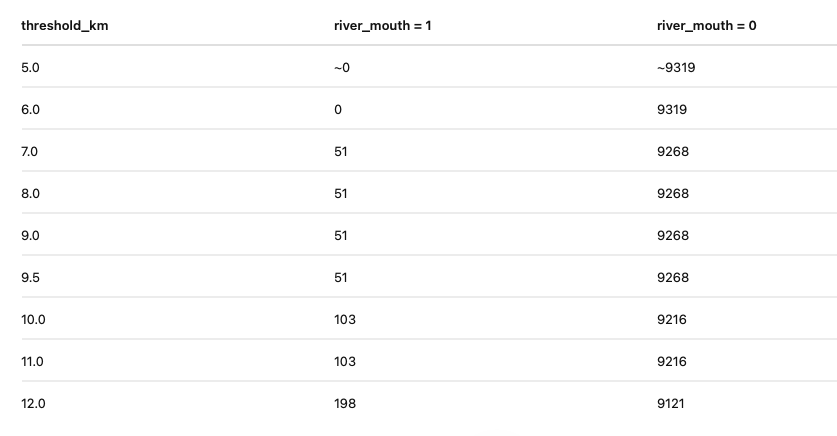

## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band swir22, NDMI and MNDWI from the Landsat data and pet from Terraclimate dataset as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the water quality parameters.</p>


<h4 style="color:rgb(255, 0, 0)"><strong>Tip 3</strong></h4>
<p align="justify">We are developing individual models for each water quality parameter using a common set of features: SWIR22, NDMI, MNDWI, and PET. However, participants are encouraged to experiment with different feature combinations to build more robust machine learning models.</p>

## Helper Functions
### Train and Test Split
<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

### Feature Scaling

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of 'swir22','NDMI','MNDWI','pet' variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler. The idea behind Standard Scaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.</p>

### Model Training
<p align="justify">
Now that we have the data in a format suitable for machine learning, we can begin training our models. In this demonstration notebook, we will build three separate regression models — one for each target water quality parameter: Total Alkalinity, Electrical Conductance, and Dissolved Reactive Phosphorus.
Each model will be trained independently to capture the unique relationships between the satellite-derived features and each parameter.
</p>

<p align="justify">
We will use the Random Forest Regressor from the scikit-learn library to build our models. Scikit-learn provides a wide range of regression algorithms with extensive parameter tuning and customization capabilities.
</p>

<p align="justify">
For model training, the predictor variables (e.g., SWIR22, NDMI, MNDWI, and pet) will be stored in an array X, and the response variable (one of the three water quality parameters) will be stored in an array Y.
It is important not to include the response variable in X. Additionally, since latitude, longitude, and sample date are only used for spatial and temporal reference, they will be excluded from the predictor variables during model training.
</p>

### Model Evaluation
<p align="justify">
Now that we have trained our models for the three water quality parameters, the next step is to evaluate their performance. Each regression model for Total Alkalinity, Electrical Conductance, and Dissolved Reactive Phosphorus is assessed using the R² score and the Root Mean Square Error (RMSE). The R² score measures how well the model explains the variance in the observed values, while RMSE quantifies the average magnitude of prediction errors. Together, these metrics help determine how effectively each model captures variations in water quality across different locations and sampling dates. Scikit-learn provides built-in functions to compute these metrics, and participants may explore additional evaluation methods or custom metrics as needed.</p>


<h4 style="color:rgb(255, 0, 0)"><strong>Tip 4</strong></h4>
<p align="justify">There are many data preprocessing methods available, which might help to improve the model performance. Participants should explore various suitable preprocessing methods as well as different machine learning algorithms to build a robust model.</p>

In [ ]:
def split_data(X, y, test_size=0.3, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

def train_model(X_train_scaled, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    return model

def evaluate_model(model, X_scaled, y_true, dataset_name="Test"):
    y_pred = model.predict(X_scaled)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n{dataset_name} Evaluation:")
    print(f"R²: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    return y_pred, r2, rmse

<div class="section">
  <h2>Model Workflow (Pipeline)</h2>
  <p align="justify">
    The complete model development process follows a structured pipeline to ensure consistency, reproducibility, and clarity.
    Each stage in the workflow is modularized into independent functions, which can be reused for different water quality parameters.
    This modular approach helps streamline the process and makes the workflow easily adaptable to new datasets or parameters in the future.
  </p>

  <p align="justify">
    The pipeline automates the sequence of steps — from data preparation to evaluation — for each target parameter.
    The same set of predictor variables is used, while the response variable changes for each of the three targets:
    <i>Total Alkalinity (TA)</i>, <i>Electrical Conductance (EC)</i>, and <i>Dissolved Reactive Phosphorus (DRP)</i>.
    By maintaining a consistent framework, comparisons across models remain fair and interpretable.
  </p>


In [ ]:
def run_pipeline(X, y, param_name="Parameter"):
    print(f"\n{'='*60}")
    print(f"Training Model for {param_name}")
    print(f"{'='*60}")

    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Scale
    X_train_scaled, X_test_scaled, scaler = scale_data(X_train, X_test)

    # Train
    model = train_model(X_train_scaled, y_train)

    # Evaluate (in-sample)
    y_train_pred, r2_train, rmse_train = evaluate_model(model, X_train_scaled, y_train, "Train")

    # Evaluate (out-sample)
    y_test_pred, r2_test, rmse_test = evaluate_model(model, X_test_scaled, y_test, "Test")

    # Return summary
    results = {
        "Parameter": param_name,
        "R2_Train": r2_train,
        "RMSE_Train": rmse_train,
        "R2_Test": r2_test,
        "RMSE_Test": rmse_test
    }
    return model, scaler, pd.DataFrame([results])

### Model Training and Evaluation for Each Parameter

<p align="justify">In this step, we apply the complete modeling pipeline to each of the three selected water quality parameters — Total Alkalinity, Electrical Conductance, and Dissolved Reactive Phosphorus. The input feature set (<code>X</code>) remains the same across all three models, while the target variable (<code>y</code>) changes for each parameter. For every parameter, the <code>run_pipeline()</code> function is executed, which handles data preprocessing, model training, and both in-sample and out-of-sample evaluation. This ensures a consistent workflow and allows for a fair comparison of model performance across different water quality indicators.</p>

In [ ]:
X = wq_data.drop(columns=['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus'])

y_TA = wq_data['Total Alkalinity']
y_EC = wq_data['Electrical Conductance']
y_DRP = wq_data['Dissolved Reactive Phosphorus']

model_TA, scaler_TA, results_TA = run_pipeline(X, y_TA, "Total Alkalinity")
model_EC, scaler_EC, results_EC = run_pipeline(X, y_EC, "Electrical Conductance")
model_DRP, scaler_DRP, results_DRP = run_pipeline(X, y_DRP, "Dissolved Reactive Phosphorus")



Training Model for Total Alkalinity


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)

### Model Performance Summary

<p align="justify">After training and evaluating the models for each water quality parameter, the individual performance metrics are combined into a single summary table. This table consolidates the R² and RMSE values for both in-sample and out-of-sample evaluations, enabling an easy comparison of model performance across Total Alkalinity, Electrical Conductance, and Dissolved Reactive Phosphorus. Such a summary provides a quick overview of how well each model captures the variability in the respective parameter and highlights any differences in predictive accuracy.</p>

In [ ]:
results_summary = pd.concat([results_TA, results_EC, results_DRP], ignore_index=True)
results_summary


## Submission

<p align="justify">Once you are satisfied with your model’s performance, you can proceed to make predictions for unseen data. To do this, use your trained model to estimate the concentrations of the target water quality parameters — Total Alkalinity, Electrical Conductance, and Dissolved Reactive Phosphorus — for a set of test locations provided in the "Submission_template.csv" file. The predicted results can then be uploaded to the challenge platform for evaluation.</p>

In [ ]:
file_path3 = "/content/drive/My Drive/2026 EY Data Challenge/Dataset/submission_template.csv"

In [ ]:
#Reading the coordinates for the submission
test_file = pd.read_csv(file_path3)
test_file.head()

<p align="justify">
Similarly, participants can use the <b>Landsat</b> and <b>TerraClimate</b> data extraction demonstration notebooks to produce feature CSVs for their <b>validation</b> data. For convenience, we have already computed and saved example validation outputs as <code>landsat_features_val_V3.csv</code> and <code>Terraclimate_val_df_v3.csv</code>. Participants should save their own extracted files in the same format and column schema; doing so will allow this benchmark notebook to load the validation features directly and run smoothly.
</p>


In [ ]:
file_path4 = "/content/drive/My Drive/2026 EY Data Challenge/Dataset/landsat_features_validation.csv"
file_path5 = "/content/drive/My Drive/2026 EY Data Challenge/Dataset/terraclimate_features_validation.csv"

In [ ]:
landsat_val_features = pd.read_csv(file_path4)
landsat_val_features.head()

In [ ]:
Terraclimate_val_df = pd.read_csv(file_path5)
Terraclimate_val_df.head()

In [ ]:
#Consolidate all the extracted bands and features in a single dataframe
val_data = pd.DataFrame({
    'Longitude': landsat_val_features['Longitude'].values,
    'Latitude': landsat_val_features['Latitude'].values,
    'Sample Date': landsat_val_features['Sample Date'].values,
    'nir': landsat_val_features['nir'].values,
    'green': landsat_val_features['green'].values,
    'swir16': landsat_val_features['swir16'].values,
    'swir22': landsat_val_features['swir22'].values,
    'NDMI': landsat_val_features['NDMI'].values,
    'MNDWI': landsat_val_features['MNDWI'].values,
    'pet': Terraclimate_val_df['pet'].values,
})

In [ ]:
# Impute the missing values
val_data = val_data.fillna(val_data.median(numeric_only=True))

In [ ]:
# Extracting specific columns (B01, B06, and NDVI) from the validation dataset
submission_val_data=val_data.loc[:,['swir22','NDMI','MNDWI','pet']]
submission_val_data.head()

In [ ]:
submission_val_data.shape

In [ ]:
# --- Predicting for Total Alkalinity ---
X_sub_scaled_TA = scaler_TA.transform(submission_val_data)
pred_TA_submission = model_TA.predict(X_sub_scaled_TA)

# --- Predicting for Electrical Conductance ---
X_sub_scaled_EC = scaler_EC.transform(submission_val_data)
pred_EC_submission = model_EC.predict(X_sub_scaled_EC)

# --- Predicting for Dissolved Reactive Phosphorus ---
X_sub_scaled_DRP = scaler_DRP.transform(submission_val_data)
pred_DRP_submission = model_DRP.predict(X_sub_scaled_DRP)

In [ ]:
submission_df = pd.DataFrame({
    'Longitude': test_file['Longitude'].values,
    'Latitude': test_file['Latitude'].values,
    'Sample Date': test_file['Sample Date'].values,
    'Total Alkalinity': pred_TA_submission,
    'Electrical Conductance': pred_EC_submission,
    'Dissolved Reactive Phosphorus': pred_DRP_submission
})

In [ ]:
#Displaying the sample submission dataframe
submission_df.head()

In [ ]:
#Dumping the predictions into a csv file.
submission_df.to_csv("submission.csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.

## Conclusion

<div align ="justify">Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!</div>